## Модель прогнозирования оттока клиентов

Необходимо построить модель прогнозирования оттока клиентов по имеющимся признакам (колонка churn в файле – целевая переменная), кратко описать методику подготовки данных, построения модели и оценки её качества. Желательно провести анализ полученных результатов и оценить практическую применимость модели.
Результат может быть представлен, например, в виде jupyter-ноутбука с кодом. Данные находятся по ссылке: https://opendatascience.slack.com/files/U710D2PPX/FK3DFV538/telco-customer-churn.csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier,LogisticRegression 
from sklearn.metrics import accuracy_score,classification, confusion_matrix,classification_report,precision_score, recall_score, roc_auc_score 
import eli5
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
init_notebook_mode(connected=True)
from IPython.display import Image

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from sklearn import cr

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
df = pd.read_csv('data/telco-customer-churn.csv')

In [4]:
df = df.drop_duplicates(subset=df.columns)

In [5]:
df[(df.customerid == 1)]

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.0,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.0,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,3981,995,0,2015,2


In [6]:
df.shape

(20468, 29)

In [7]:
df.head()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
0,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,5971,663,0,2015,1
1,12,168147,0.06,0.00,4251078442,1,Yes,Bachelor or equivalent,Male,Yes,...,15,19,No,No,0.82,3981,995,0,2015,2
2,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,7379,737,0,2015,1
3,42,29047,0.05,0.01,4251043419,2,Yes,Bachelor or equivalent,Female,Yes,...,212,34,No,Yes,0.27,1729,432,0,2015,2
4,58,27076,0.07,0.02,4251055773,3,Yes,Master or equivalent,Female,Yes,...,216,144,No,No,0.48,3122,624,0,2015,1


### Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20468 entries, 0 to 20467
Data columns (total 29 columns):
age                                     20468 non-null int64
annualincome                            20468 non-null int64
calldroprate                            20468 non-null float64
callfailurerate                         20468 non-null float64
callingnum                              20468 non-null int64
customerid                              20468 non-null int64
customersuspended                       20468 non-null object
education                               20468 non-null object
gender                                  20468 non-null object
homeowner                               20468 non-null object
maritalstatus                           20468 non-null object
monthlybilledamount                     20468 non-null int64
noadditionallines                       20468 non-null object
numberofcomplaints                      20468 non-null int64
numberofmonthunpaid        

In [9]:
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())


Features : 
 ['age', 'annualincome', 'calldroprate', 'callfailurerate', 'callingnum', 'customerid', 'customersuspended', 'education', 'gender', 'homeowner', 'maritalstatus', 'monthlybilledamount', 'noadditionallines', 'numberofcomplaints', 'numberofmonthunpaid', 'numdayscontractequipmentplanexpiring', 'occupation', 'penaltytoswitch', 'state', 'totalminsusedinlastmonth', 'unpaidbalance', 'usesinternetservice', 'usesvoiceservice', 'percentagecalloutsidenetwork', 'totalcallduration', 'avgcallduration', 'churn', 'year', 'month']

Missing values :   0

Unique values :  
 age                                       68
annualincome                            9508
calldroprate                               8
callfailurerate                            4
callingnum                              9525
customerid                              9525
customersuspended                          2
education                                  4
gender                                     2
homeowner            

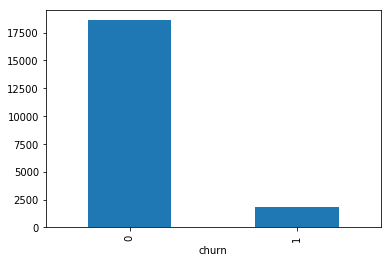

In [10]:
df.groupby('churn').size().plot(kind='bar')

In [11]:
y_True = df[(df.churn == 1)]
print ("Churn Percentage = "+str( (y_True.shape[0] / df["churn"].shape[0]) * 100 ))

Churn Percentage = 9.10201289818253


In [12]:
df.describe()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,monthlybilledamount,numberofcomplaints,numberofmonthunpaid,numdayscontractequipmentplanexpiring,penaltytoswitch,totalminsusedinlastmonth,unpaidbalance,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
count,20468.000000,20468.000000,20468.000000,20468.000000,2.046800e+04,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.0,20468.000000
mean,45.334327,124446.818253,0.035021,0.015239,4.220203e+09,4757.953342,59.630252,1.499169,3.489252,49.366816,248.792603,249.740522,126.656879,0.496528,3521.696306,721.521057,0.091020,2015.0,1.611687
std,19.624577,72129.392001,0.022996,0.011213,3.365196e+08,2751.070062,34.652681,1.119153,2.289740,28.874138,144.247247,144.198066,70.367800,0.288220,1959.642260,225.677596,0.287645,0.0,0.621895
min,12.000000,4.000000,0.000000,0.000000,1.022955e+08,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.0,1.000000
25%,28.000000,61898.000000,0.010000,0.010000,4.251031e+09,2372.750000,29.000000,0.000000,1.000000,24.000000,124.000000,126.000000,66.000000,0.250000,2047.750000,582.000000,0.000000,2015.0,1.000000
50%,45.000000,123689.500000,0.040000,0.020000,4.251054e+09,4754.000000,60.000000,2.000000,3.000000,49.000000,249.000000,249.000000,122.000000,0.500000,3365.000000,721.000000,0.000000,2015.0,2.000000
75%,62.000000,187065.250000,0.060000,0.030000,4.251077e+09,7141.250000,90.000000,3.000000,5.000000,74.000000,373.000000,374.000000,191.000000,0.750000,4786.250000,862.000000,0.000000,2015.0,2.000000
max,79.000000,249987.000000,0.070000,0.030000,4.251100e+09,9525.000000,119.000000,3.000000,7.000000,99.000000,499.000000,499.000000,249.000000,0.990000,16662.000000,1439.000000,1.000000,2015.0,3.000000


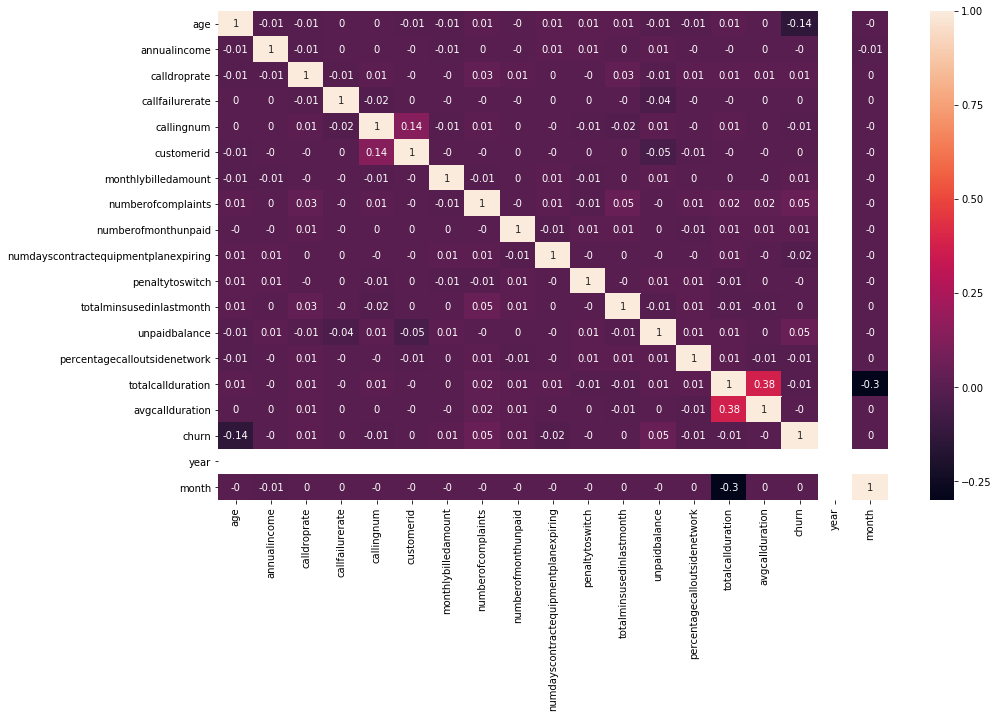

In [13]:
corr_matrix = df.corr().round(2)
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
sns.heatmap(corr_matrix,annot=True)

Величины с наибольшей корреляцией между churn и age

In [14]:
df.year.unique()

array([2015])

Признак year бесполезен

In [15]:
df = df.drop(columns='year')

In [16]:
df.noadditionallines.value_counts()

\N    20468
Name: noadditionallines, dtype: int64

In [17]:
df = df.drop(columns='noadditionallines')

И noadditionallines тоже

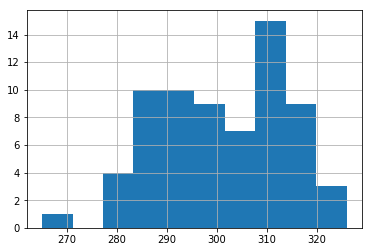

In [18]:
df.age.value_counts().hist()

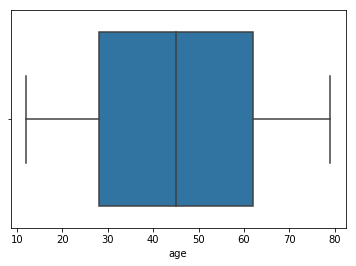

In [19]:
sns.boxplot(df.age)

In [20]:
df.age.value_counts().sort_values(ascending=False).head()

20    326
18    322
37    320
58    319
44    318
Name: age, dtype: int64

Возраст клиентов в среднем распределен равномерно

**Cколько в среднем в течение месяца разговаривают по телефону нелояльные пользователи?**

In [21]:
df[df['churn'] == 1]['avgcallduration'].mean()

720.179817498658

А лояльные?

In [22]:
df[df['churn'] == 0]['avgcallduration'].mean()

721.6553614619726

**Признак – "Число жалоб" (numberofcomplaints)**

In [23]:
pd.crosstab(df['churn'], df['numberofcomplaints'], margins=True)

numberofcomplaints,0,1,2,3,All
churn,,,,,
0,4716,4711,4713,4465,18605
1,425,376,409,653,1863
All,5141,5087,5122,5118,20468


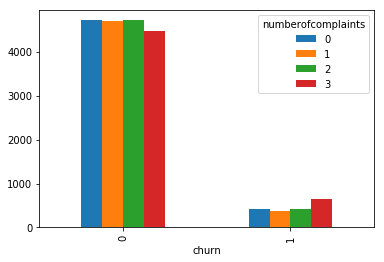

In [24]:
pd.crosstab(df['churn'], df['numberofcomplaints']).plot(kind='bar')

Число  недовольных клиентов, которые отказались от услуг, больше с каждым последующим звонком, начиная с 2.

**Признак – "Число неоплаченных месяцев" (numberofmonthunpaid)**

In [25]:
pd.crosstab(df['churn'], df['numberofmonthunpaid'], margins=True)

numberofmonthunpaid,0,1,2,3,4,5,6,7,All
churn,,,,,,,,,
0,2352,2312,2333,2387,2280,2368,2263,2310,18605
1,233,244,213,213,240,249,240,231,1863
All,2585,2556,2546,2600,2520,2617,2503,2541,20468


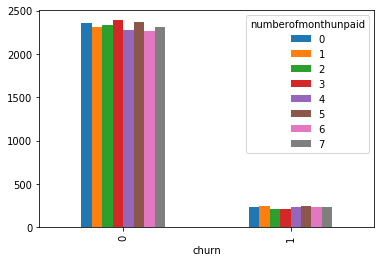

In [26]:
pd.crosstab(df['churn'], df['numberofmonthunpaid']).plot(kind='bar')

В наших данных в среднем равномерно растределено как для клиентов, отказавшихся от услуг, так и для тех, кто не отказался.

**Признак - "Процент зафэйленых  звонков" (наверно, по причине оператора)**

In [27]:
pd.crosstab(df['churn'], df['callfailurerate'], margins=True)

callfailurerate,0.0,0.01,0.02,0.03,All
churn,,,,,
0,4500,4752,4482,4871,18605
1,456,439,481,487,1863
All,4956,5191,4963,5358,20468


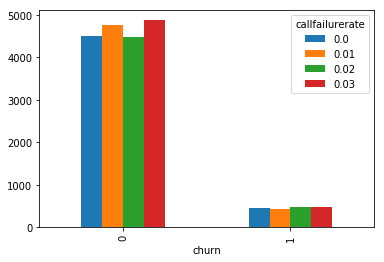

In [28]:
pd.crosstab(df['churn'], df['callfailurerate']).plot(kind='bar')

Явной тенденции снова нет

### Feature extraction

Object

In [29]:
df.select_dtypes('object').head()

,customersuspended,education,gender,homeowner,maritalstatus,occupation,state,usesinternetservice,usesvoiceservice
0,Yes,Bachelor or equivalent,Male,Yes,Single,Technology Related Job,WA,No,No
1,Yes,Bachelor or equivalent,Male,Yes,Single,Technology Related Job,WA,No,No
2,Yes,Bachelor or equivalent,Female,Yes,Single,Technology Related Job,WI,No,Yes
3,Yes,Bachelor or equivalent,Female,Yes,Single,Technology Related Job,WI,No,Yes
4,Yes,Master or equivalent,Female,Yes,Single,Technology Related Job,KS,No,No


In [30]:
yes_no_feat = ['customersuspended','homeowner','usesinternetservice','usesvoiceservice']

In [31]:
for feat in yes_no_feat:
    df[feat] = df[feat].apply(lambda x: 1 if x == 'Yes' else 0)

In [32]:
df['maritalstatus'] = df['maritalstatus'].apply(lambda x: 1 if x != 'Single' else 0)

In [33]:
df['gender'] = df['gender'].apply(lambda x: 1 if x != 'Male' else 0)

In [34]:
df['occupation'] = df['occupation'].str.replace(' ','')
df['education'] = df['education'].str.replace(' ','')

In [35]:
df_state = pd.get_dummies(df.state,prefix='st',prefix_sep='_')
df_occupation = pd.get_dummies(df.occupation,prefix='occ',prefix_sep='_')
df_educ = pd.get_dummies(df.education, prefix='educ', prefix_sep="_")

In [36]:
df = pd.concat([df, df_state, df_occupation, df_educ], axis=1, join_axes=[df.index])

In [37]:
df.select_dtypes('object').head()

,education,occupation,state
0,Bachelororequivalent,TechnologyRelatedJob,WA
1,Bachelororequivalent,TechnologyRelatedJob,WA
2,Bachelororequivalent,TechnologyRelatedJob,WI
3,Bachelororequivalent,TechnologyRelatedJob,WI
4,Masterorequivalent,TechnologyRelatedJob,KS


In [38]:
df = df.reset_index(drop=True).drop(columns=['education','occupation','state'])

In [39]:
df.shape

(20468, 81)

In [40]:
df.head()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,gender,homeowner,maritalstatus,...,st_WI,st_WV,st_WY,occ_Non-technologyRelatedJob,occ_Others,occ_TechnologyRelatedJob,educ_Bachelororequivalent,educ_HighSchoolorbelow,educ_Masterorequivalent,educ_PhDorequivalent
0,12,168147,0.06,0.00,4251078442,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
1,12,168147,0.06,0.00,4251078442,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
2,42,29047,0.05,0.01,4251043419,2,1,1,1,0,...,1,0,0,0,0,1,1,0,0,0
3,42,29047,0.05,0.01,4251043419,2,1,1,1,0,...,1,0,0,0,0,1,1,0,0,0
4,58,27076,0.07,0.02,4251055773,3,1,1,1,0,...,0,0,0,0,0,1,0,0,1,0


### Строим и тренируем базовые модели

Делим на X и y

In [41]:
y = df['churn']
X = df.drop(columns=['churn', 'callingnum'])

In [42]:
# Spot Check Algorithms
models = []
models.append(('Gradient Boosting Classifier ' , GradientBoostingClassifier()))
# models.append(('Support vector machine(SVM)  ' , SVC()))
models.append(('Random Forest Classifier     ' , RandomForestClassifier()))
models.append(('K Nearest Neighbor Classifier' , KNeighborsClassifier()))
models.append(('Logistic Regression          ' , LogisticRegression()))
models.append(('LGBMClassifier               ' , LGBMClassifier()))
models.append(('XGBClassifier                ' , XGBClassifier()))

In [43]:
def my_cv_acc(data,target,model,transform_list=[],metrics='accuracy'):
    results = []
    cv = KFold(n_splits=5, random_state=17, shuffle=True)
    for train_ind, val_ind in cv.split(data, target):
        
        X_train_ = data.loc[train_ind]
        y_train_ = target.loc[train_ind]
        X_val_ = data.loc[val_ind]
        y_val_ = target.loc[val_ind]
        
        if len(transform_list) == 0:
            for col in transform_list:

                ss = StandardScaler()
                scale_var_train = X_train_[col].values.reshape(-1, 1)
                scale_var_train = ss.fit_transform(scale_var_train)

                scale_var_val = X_val_[col].values.reshape(-1, 1)
                scale_var_val = ss.transform(scale_var_val)

                X_train[col] = scale_var_train
                X_val[col] = scale_var_val

        model.fit(X_train_,y_train_)
        y_pred_ = model.predict(X_val_)
            
        if metrics == 'accuracy':
            sc = accuracy_score(y_val_,y_pred_)
        elif metrics == 'precision':
            sc = precision_score(y_val_,y_pred_)
        elif metrics == 'recall':
            sc = recall_score(y_val_,y_pred_)
        elif metrics == 'roc_auc':
            sc = roc_auc_score(y_val_,y_pred_)
        
        results.append(sc)
    return results

In [44]:
for name, model in models:
    results = my_cv_acc(X,y,model,transform_list=X.columns)
    msg = "%s: accuracy:%f " % (name,np.mean(results))
    print(msg)

Gradient Boosting Classifier : accuracy:0.909566 
Random Forest Classifier     : accuracy:0.936388 
K Nearest Neighbor Classifier: accuracy:0.901603 
Logistic Regression          : accuracy:0.908980 
LGBMClassifier               : accuracy:0.920266 
XGBClassifier                : accuracy:0.908980 


In [45]:
for name, model in models:
    results = my_cv_acc(X,y,model,metrics='recall',transform_list=X.columns)
    msg = "%s: recall:%f " % (name,np.mean(results))
    print(msg)

Gradient Boosting Classifier : recall:0.006472 
Random Forest Classifier     : recall:0.337485 
K Nearest Neighbor Classifier: recall:0.034419 
Logistic Regression          : recall:0.000000 
LGBMClassifier               : recall:0.127390 
XGBClassifier                : recall:0.000000 


In [46]:
def make_pred(X,y,model):
    results = []
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=17)
    
    for col in X.columns:
        ss = StandardScaler()
        X_train[col] = ss.fit_transform(X_train[col].values.reshape(-1, 1))
        X_test[col] = ss.transform(X_test[col].values.reshape(-1, 1))

    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    return y_test, y_pred

In [47]:
def plot_conf_matrix(X,y,model,title):
    y_test, y_pred = make_pred(X,y,model)
    plt.figure()
    grad_ens_conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(grad_ens_conf_matrix, annot=True,  fmt='')
    plt.title(title)

Confusion Matrices for various models

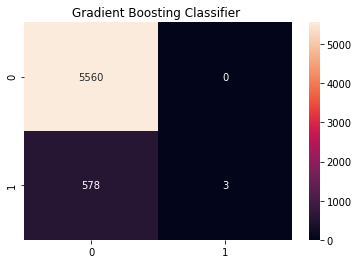

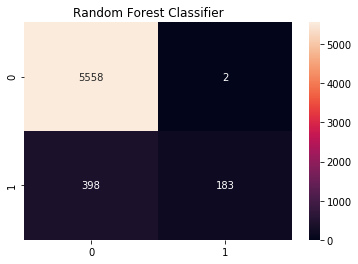

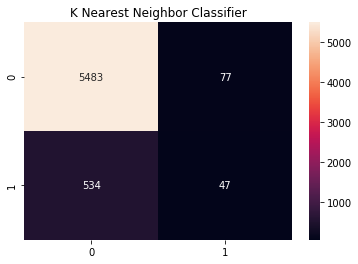

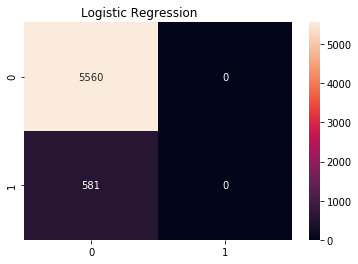

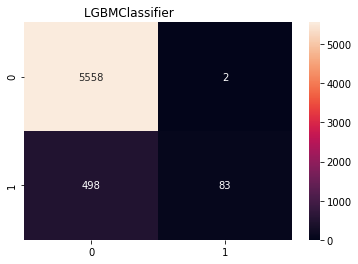

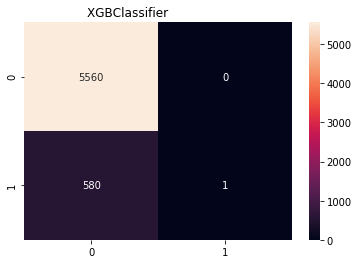

In [48]:
for name, model in models:
    plot_conf_matrix(X,y,model,name)

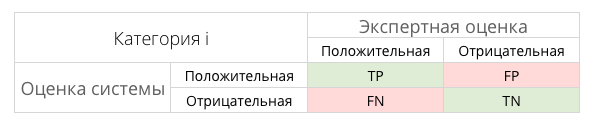

In [49]:
Image(filename='table.png') 

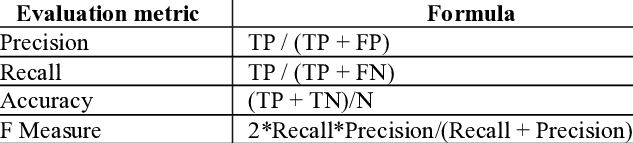

In [50]:
Image(filename='ClassificationMetrics.png') 

Проблема с метрикой accuracy заключается в том, что результаты не обязательно эквивалентны. Если классификатор спрогнозирует уход клиента, но клиент останется, – это не очень хорошо, но простительно. Однако если классификатор предскажет, что клиент не уйдет, я не стану предпринимать никакие действия, а клиент все же уйдет – это уже действительно плохо.

Важным вопросом является следующий: «Каково отношение количества правильно спрогнозированных уходов к общему количеству фактических уходов?» Эта метрика имеет название «полнота» (recall). 

In [51]:
for name,model in models:
    y_true_, y_pred_ = make_pred(X,y,model)
    print(name,':\n {}\n'.format(classification_report(y_true_, y_pred_)))

Gradient Boosting Classifier  :
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      5560
           1       1.00      0.01      0.01       581

   micro avg       0.91      0.91      0.91      6141
   macro avg       0.95      0.50      0.48      6141
weighted avg       0.91      0.91      0.86      6141


Random Forest Classifier      :
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      5560
           1       0.99      0.30      0.46       581

   micro avg       0.93      0.93      0.93      6141
   macro avg       0.96      0.65      0.71      6141
weighted avg       0.94      0.93      0.92      6141


K Nearest Neighbor Classifier :
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      5560
           1       0.38      0.08      0.13       581

   micro avg       0.90      0.90      0.90      6141
   macro avg       0.65    

По умолчанию кол-во деревьев в RandomForest = 10. В LGBMClassifier и XGBClassifier - 100.

In [52]:
# accuracy
print('RandomForestClassifier(n_estimators=300) accuracy:',np.mean(my_cv_acc(
    X,y,RandomForestClassifier(n_estimators=300),transform_list=X.columns)))
print('LGBMClassifier(n_estimators=300)',np.mean(my_cv_acc(
    X,y,LGBMClassifier(n_estimators=300),transform_list=X.columns)))

RandomForestClassifier(n_estimators=300) accuracy: 0.9467950154033524
LGBMClassifier(n_estimators=300) 0.9607190108912581


In [53]:
# recall
print('RandomForestClassifier(n_estimators=300) recall:',np.mean(my_cv_acc(
    X,y,RandomForestClassifier(n_estimators=300),metrics='recall',transform_list=X.columns)))
print('LGBMClassifier(n_estimators=300) recall:',np.mean(my_cv_acc(
    X,y,LGBMClassifier(n_estimators=300),metrics='recall',transform_list=X.columns)))

RandomForestClassifier(n_estimators=300) recall: 0.41531776594990094
LGBMClassifier(n_estimators=300) recall: 0.5761329059024843


In [54]:
# recall
print('RandomForestClassifier(n_estimators=300) roc_auc:',np.mean(my_cv_acc(
    X,y,RandomForestClassifier(n_estimators=300),metrics='roc_auc',transform_list=X.columns)))
print('LGBMClassifier(n_estimators=300) roc_auc:',np.mean(my_cv_acc(
    X,y,LGBMClassifier(n_estimators=300),metrics='roc_auc',transform_list=X.columns)))

RandomForestClassifier(n_estimators=300) roc_auc: 0.7039095771789253
LGBMClassifier(n_estimators=300) roc_auc: 0.7876904526912861


С увеличением числа деревьев LGBMClassifier оценка как accuracy так и recall возрастает и становится больше оценки RandomForestClassifier

In [55]:
%time
range_estimators = list(range(60, 511, 50))
tree_params = {'n_estimators': range_estimators}
scores_lgbm = []
scores_rf = []
for n in tree_params['n_estimators']:
    model = LGBMClassifier(n_estimators=n,random_state=17,n_jobs=-1)
    sc = my_cv_acc(X,y,model,transform_list=X.columns)
    scores_lgbm.append(np.mean(sc))
for n in tree_params['n_estimators']:
    model = RandomForestClassifier(n_estimators=n,random_state=17,n_jobs=-1)
    sc = my_cv_acc(X,y,model)
    scores_rf.append(np.mean(sc))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [56]:
trace0 = go.Scatter(
    x=range_estimators,
    y=scores_rf,
    name='Random Forest Classifier'
)

trace1 = go.Scatter(
    x=range_estimators,
    y=scores_lgbm,
    name='LGBM Classifier'
)

data = [trace0, trace1]
layout = go.Layout(title = 'Кривые валидации по подбору количества деревьев для RandomForest и LGBM',
          yaxis={'title':'Accuracy'}, xaxis={'title':'Кол-во деревьев'})

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

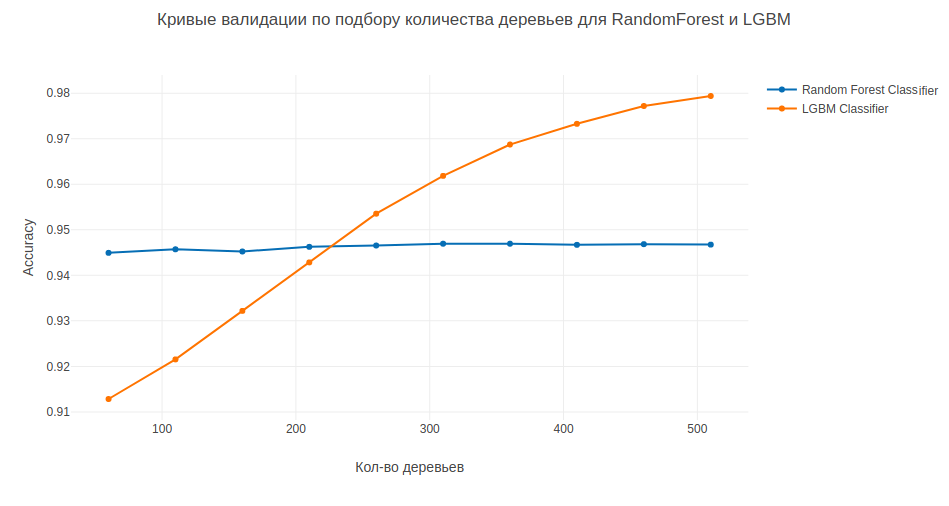

In [57]:
Image(filename='count_tree_accuracy.png') 

In [58]:
%time
scores_lgbm_recall = []
scores_rf_recall = []
for n in tree_params['n_estimators']:
    model = LGBMClassifier(n_estimators=n,random_state=17,n_jobs=-1)
    sc = my_cv_acc(X,y,model,metrics='recall',transform_list=X.columns)
    scores_lgbm_recall.append(np.mean(sc))
for n in tree_params['n_estimators']:
    model = RandomForestClassifier(n_estimators=n,random_state=17,n_jobs=-1)
    sc = my_cv_acc(X,y,model,metrics='recall')
    scores_rf_recall.append(np.mean(sc))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


In [59]:
trace0 = go.Scatter(
    x=range_estimators,
    y=scores_rf_recall,
    name='Random Forest Classifier'
)

trace1 = go.Scatter(
    x=range_estimators,
    y=scores_lgbm_recall,
    name='LGBM Classifier'
)

data = [trace0, trace1]
layout = go.Layout(title = 'Кривые валидации по подбору количества деревьев для RandomForest и LGBM',
          yaxis={'title':'Recall'}, xaxis={'title':'Кол-во деревьев'})

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

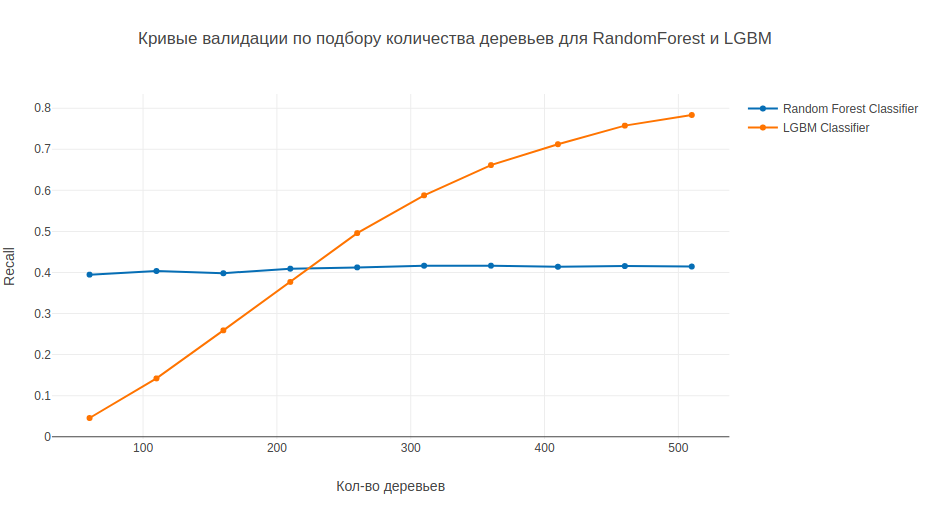

In [60]:
Image(filename='count_tree_recall.png') 

Качество LGBMClassifier растет при увеличении кол-ва деревьев. После 200 деревьев оценка LGBMClassifier выше RandomForestClassifier. Чем больше деревьев, тем лучше. (в рамках анализа 500 - максимум)

In [61]:
lgbm = LGBMClassifier(n_estimators=200,max_depth=50,n_jobs=-1)
lgbm.fit(StandardScaler().fit_transform(X), y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=50,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Можно оценить вклад признаков в предсказании.

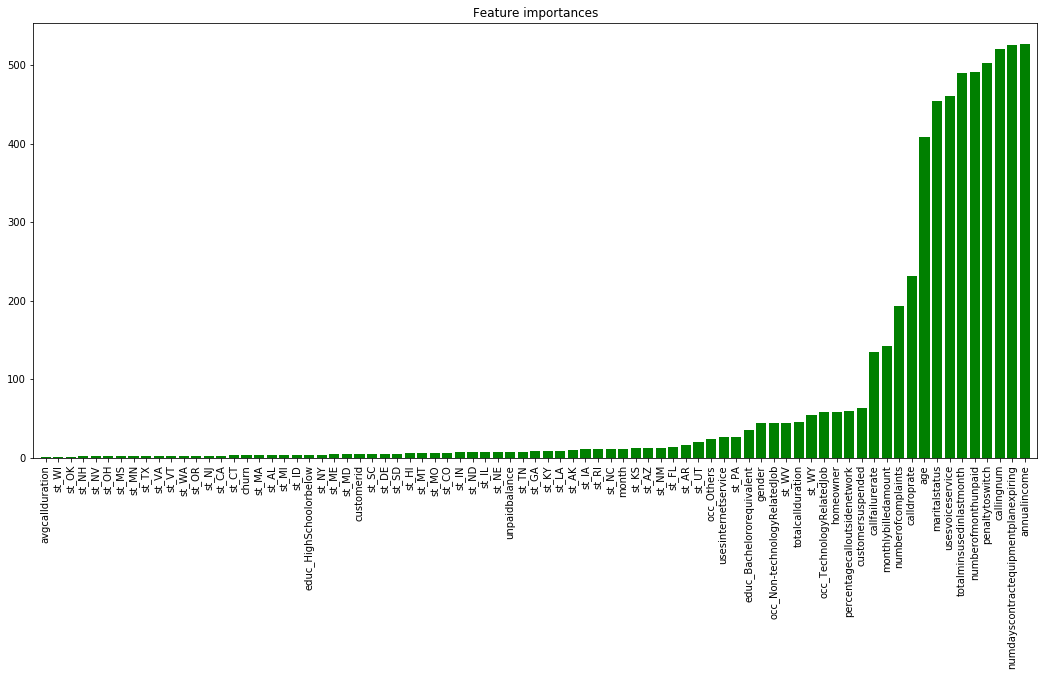

In [62]:
feat_names = df.columns
importances = lgbm.feature_importances_
indices = np.argsort(importances)
# indices = np.concatenate([np.argsort(importances)[::-1][:15],np.argsort(importances)[::-1][-15:]])

plt.figure(figsize=(18,8))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="g", align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

Можно заметить ряд признаков, которые делают наименьший вклад в качество модели. Попробуем их удалить и посмотреть что будет.

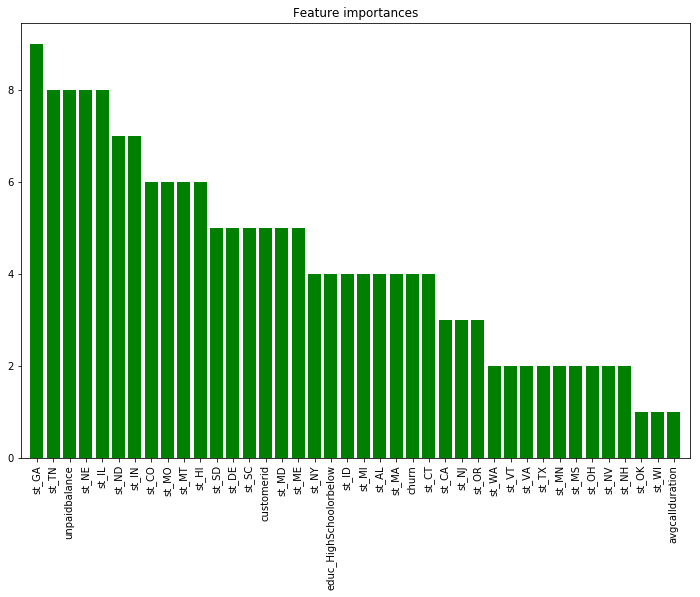

In [63]:
less_important = indices[::-1][-40:]
plt.figure(figsize=(12,8))
plt.title("Feature importances")
plt.bar(range(len(less_important)), importances[less_important], color="g", align="center")
plt.xticks(range(len(less_important)), feat_names[less_important], rotation='vertical')
plt.xlim([-1, len(less_important)])
plt.show()

### Feature selection (отсечение ненужных признаков)

In [64]:
feat_names[less_important]

Index(['st_GA', 'st_TN', 'unpaidbalance', 'st_NE', 'st_IL', 'st_ND', 'st_IN',
       'st_CO', 'st_MO', 'st_MT', 'st_HI', 'st_SD', 'st_DE', 'st_SC',
       'customerid', 'st_MD', 'st_ME', 'st_NY', 'educ_HighSchoolorbelow',
       'st_ID', 'st_MI', 'st_AL', 'st_MA', 'churn', 'st_CT', 'st_CA', 'st_NJ',
       'st_OR', 'st_WA', 'st_VT', 'st_VA', 'st_TX', 'st_MN', 'st_MS', 'st_OH',
       'st_NV', 'st_NH', 'st_OK', 'st_WI', 'avgcallduration'],
      dtype='object')

In [65]:
df_test = df.drop(columns=feat_names[less_important])

Х с слабыми признаками и без них

X with weak features vs X without they

In [66]:
print('With weak feats roc_auc: ',np.mean(my_cv_acc(X,y,lgbm,metrics='roc_auc',transform_list=X.columns)))
print('Without weak feats roc_auc: ',np.mean(my_cv_acc(df_test,y,lgbm,metrics='roc_auc',transform_list=df_test.columns)))

With weak feats roc_auc:  0.6871183183213927
Without weak feats roc_auc:  0.6632545482823031


In [67]:
print('With weak feats recall:',np.mean(my_cv_acc(X,y,lgbm,metrics='recall',transform_list=X.columns)))
print('Without weak feats recall:',np.mean(my_cv_acc(df_test,y,lgbm,metrics='recall',transform_list=df_test.columns)))

With weak feats recall: 0.3749885519182958
Without weak feats recall: 0.3267235747630123


Качество немного упало, лучше данные признаки не удалять.

### Представление оттока в виде вероятностей

Часто предпочтительнее опираться на вероятность, чем на обычную классификацию. Таким образом, каждый раз, когда мы предсказываем, что событие произойдет, мы можем узнать, как часто это событие происходит на самом деле и посчитать вероятность.

In [68]:
def run_prob_cv(X, y, clf):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for train_index, test_index in kf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf.fit(X_train,y_train)
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [69]:
X = StandardScaler().fit_transform(X)
pred_prob = run_prob_cv(X, y, lgbm)
pred_churn = pred_prob[:,1]
is_churn = y == 1

counts = pd.value_counts(pred_churn)

true_prob = {}
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
    true_prob = pd.Series(true_prob)

counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']

In [70]:
counts.head()

,pred_prob,count,true_prob
0,0.055781,3,0.0
1,0.059089,2,0.0
2,0.001208,2,0.0
3,0.007975,2,0.0
4,0.030922,2,1.0


LGBMClassifier предсказал, например, что клиент с индексом 0 имеют вероятность ухода, равную 0.000387.

In [71]:
counts.groupby('true_prob')['pred_prob'].mean()

true_prob
0.0    0.042956
1.0    0.412621
Name: pred_prob, dtype: float64

Средний показатель (порог) вероятности ухода клиента 0.404840 и 0.043456 его неухода.